In [1]:
import os 
import re
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

import multiprocessing
from multiprocessing import Pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

import lightgbm as lgb

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

In [3]:
set_seeds(715)

In [4]:
min_day = datetime.strptime('2020-10-31', '%Y-%m-%d').date()

def make_datetime(df):
    df['time'] = df['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d%H%M%S')) 
    df['date'] = df['time'].apply(lambda x: x.date())
    df['days'] = df['date'].apply(lambda x: (x-min_day).days)
    df['week'] = df['time'].apply(lambda x: x.week)
    df['hour'] = df['time'].apply(lambda x: x.hour)
    return df 

In [5]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [6]:
# train_err = pd.read_csv('dataset/train_err_data.csv')
# train_err = parallelize_dataframe(train_err, make_datetime, n_cores=8)
# train_err.to_pickle("./dataset/train_err.pkl")

In [7]:
# test_err = pd.read_csv('dataset/test_err_data.csv')
# test_err = parallelize_dataframe(test_err, make_datetime, n_cores=8)
# test_err.to_pickle("./dataset/test_err.pkl")

In [11]:
train_err = pd.read_pickle("./dataset/train_err.pkl")
test_err = pd.read_pickle("./dataset/test_err.pkl")

train_problem = pd.read_csv('dataset/train_problem_data.csv')

## Train_Err

### Poly Features 

In [9]:
def make_polycol(df):
    df['errtype'] = df['errtype'].astype('str') 
    df['errcase'] = df.iloc[:]['errtype'] + '_' + df.iloc[:]['errcode']
    df['model_errtype'] = df.iloc[:]['model_nm'] + '_' + df.iloc[:]['errtype']
    df['model_errcode'] = df.iloc[:]['model_nm'] + '_' + df.iloc[:]['errcode']
    df['model_fwver'] = df.iloc[:]['model_nm'] + '_' + df.iloc[:]['fwver']
    df['fwver_errcode'] = df.iloc[:]['fwver'] + '_' + df.iloc[:]['errcode']
    return df

In [10]:
train_err = make_polycol(train_err)
test_err = make_polycol(test_err)

KeyboardInterrupt: 

In [11]:
errcode_dict = {code:idx for idx, code in enumerate(list(train_err['errcode'].value_counts()[:30].index))}
errcase_dict = {code:idx for idx, code in enumerate(list(train_err['errcase'].value_counts()[:50].index))}
# model_fwver_dict = {code:idx for idx, code in enumerate(list(train_err['model_fwver'].value_counts()[:20].index))}
model_errtype_dict = {code:idx for idx, code in enumerate(list(train_err['model_errtype'].value_counts()[:20].index))}
model_errcode_dict = {code:idx for idx, code in enumerate(list(train_err['model_errcode'].value_counts()[:20].index))}
fwver_errcode_dict = {code:idx for idx, code in enumerate(list(train_err['fwver_errcode'].value_counts()[:50].index))}

In [12]:
def case_study(dict_case, x):
    try:
        return dict_case[x]
    except:
        return len(dict_case)

def make2group(df):
    df['errcode2'] = df['errcode'].apply(lambda x: case_study(errcode_dict, x))
    df['errcase'] = df['errcase'].apply(lambda x: case_study(errcase_dict, x))
#     df['model_fwver'] = df['model_fwver'].apply(lambda x: case_study(model_fwver_dict, x))
    df['model_errtype'] = df['model_errtype'].apply(lambda x: case_study(model_errtype_dict, x))
    df['model_errcode'] = df['model_errcode'].apply(lambda x: case_study(model_errcode_dict, x))
    df['fwver_errcode'] = df['fwver_errcode'].apply(lambda x: case_study(fwver_errcode_dict, x))
    return df

In [13]:
train_err = make2group(train_err)
train_err.to_pickle("./dataset/train_err.pkl")

In [15]:
test_err = make2group(test_err)
test_err.to_pickle("./dataset/test_err.pkl")

### Time Info

In [12]:
def time_info(df):
    user_logcnt = df.groupby('user_id')['time'].nunique().reset_index(name='log_cnt')
    user_daycnt = df.groupby('user_id')['date'].nunique().reset_index(name='day_cnt')
    
    #daily
    user_daily_log = df.pivot_table(index='user_id',
                                    columns='days',
                                    values='time',
                                    aggfunc='count',
                                    fill_value=0).reset_index().add_prefix('day').add_suffix('_logcnt')
    user_daily_log.columns.name=None
    user_daily_log = user_daily_log.rename(columns={"dayuser_id_logcnt": "user_id"})
    
#     #weekly
#     user_weekly_log = df.pivot_table(index='user_id',
#                                      columns='week',
#                                      values='time',
#                                      aggfunc='count',
#                                      fill_value=0).reset_index().add_prefix('week').add_suffix('_logcnt')
#     user_weekly_log.columns.name=None
#     user_weekly_log = user_weekly_log.rename(columns={"weekuser_id_logcnt": "user_id"})
    
    # Hourly
    user_hourly_log = df.pivot_table(index='user_id',
                                     columns='hour',
                                     values='time',
                                     aggfunc='count',
                                     fill_value=0).reset_index().add_prefix('hour').add_suffix('_logcnt')
    user_hourly_log.columns.name=None
    user_hourly_log = user_hourly_log.rename(columns={"houruser_id_logcnt": "user_id"})
    
    # Merge
    process_df = pd.merge(user_logcnt, user_daycnt, how='left', on='user_id')
    process_df = pd.merge(process_df, user_daily_log, how='left', on='user_id')
    process_df = pd.merge(process_df, user_hourly_log, how='left', on='user_id')
    return process_df

In [13]:
train_time_info = time_info(train_err)
test_time_info = time_info(test_err)

### Err Info

In [14]:
def err_info(df):
    # errtype
    errtype_cnt = df.pivot_table(index='user_id', 
                                  columns='errtype', 
                                  values='time', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index().add_prefix('errtype_')
    errtype_cnt.columns.name=None
    errtype_cnt = errtype_cnt.rename(columns={"errtype_user_id": "user_id"})
    errtype_unique = df.groupby('user_id')['errtype'].nunique().reset_index(name='errtype_unum')
    
    # Errcode
    errcode_cnt = df.pivot_table(index='user_id', 
                                 columns='errcode2', 
                                 values='time', 
                                 aggfunc='count', 
                                 fill_value=0).reset_index().add_prefix('errcode_')

    errcode_cnt.columns.name=None
    errcode_cnt = errcode_cnt.rename(columns={"errcode_user_id": "user_id"})
    errcode_unique = df.groupby('user_id')['errcode'].nunique().reset_index(name='errcode_unum')
    
    
    # Errcase
    errcase_cnt = df.pivot_table(index='user_id', 
                                 columns='errcase', 
                                 values='time', 
                                 aggfunc='count', 
                                 fill_value=0).reset_index().add_prefix('errcase_')

    errcase_cnt.columns.name=None
    errcase_cnt = errcase_cnt.rename(columns={"errcase_user_id": "user_id"})
    errcase_unique = df.groupby('user_id')['errcase'].nunique().reset_index(name='errcase_unum')
    
    
    # Merge
    process_df = pd.merge(errtype_cnt, errtype_unique, how='left', on='user_id')
    process_df = pd.merge(process_df, errcode_cnt, how='left', on='user_id')
    process_df = pd.merge(process_df, errcode_unique, how='left', on='user_id')
    process_df = pd.merge(process_df, errcase_cnt, how='left', on='user_id')
    process_df = pd.merge(process_df, errcase_unique, how='left', on='user_id')
    return process_df

In [15]:
train_err_info = err_info(train_err)
test_err_info = err_info(test_err)

### Side Info

In [16]:
def side_info(df):
    # Model
    model_nm_cnt = df.pivot_table(index='user_id', 
                                  columns='model_nm', 
                                  values='time', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index().add_prefix('model_nm_')
    model_nm_cnt.columns.name=None
    model_nm_cnt = model_nm_cnt.rename(columns={"model_nm_user_id": "user_id"})
    model_nm_unique = df.groupby('user_id')['model_nm'].nunique().reset_index(name='model_nm_unum')
    
    # Fwver
    fwver_unique = df.groupby('user_id')['fwver'].nunique().reset_index(name='fwver_unum')

    
    # Model + Errtype
    merrtype_cnt = df.pivot_table(index='user_id', 
                                  columns='model_errtype', 
                                  values='time', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index().add_prefix('merrtype_')
    merrtype_cnt.columns.name=None
    merrtype_cnt = merrtype_cnt.rename(columns={"merrtype_user_id": "user_id"})
    merrtype_cnt_unique = df.groupby('user_id')['model_errtype'].nunique().reset_index(name='merrtype_unum')
    
    # Model + Errcode
    merrcode_cnt = df.pivot_table(index='user_id', 
                                  columns='model_errcode', 
                                  values='time', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index().add_prefix('merrcode_')
    merrcode_cnt.columns.name=None
    merrcode_cnt = merrcode_cnt.rename(columns={"merrcode_user_id": "user_id"})
    merrcode_cnt_unique = df.groupby('user_id')['model_errcode'].nunique().reset_index(name='merrcode_unum')
    
    
    # Fwver + Errcode
    ferrcode_cnt = df.pivot_table(index='user_id', 
                                  columns='fwver_errcode', 
                                  values='time', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index().add_prefix('ferrcode_')
    ferrcode_cnt.columns.name=None
    ferrcode_cnt = ferrcode_cnt.rename(columns={"ferrcode_user_id": "user_id"})
    ferrcode_cnt_unique = df.groupby('user_id')['fwver_errcode'].nunique().reset_index(name='ferrcode_unum')
    
    
    # Merge
    process_df = pd.merge(model_nm_cnt, model_nm_unique, how='left', on='user_id')
    process_df = pd.merge(process_df, fwver_unique, how='left', on='user_id')
    
#     process_df = pd.merge(process_df, merrtype_cnt, how='left', on='user_id')
    process_df = pd.merge(process_df, merrtype_cnt_unique, how='left', on='user_id')
    
#     process_df = pd.merge(process_df, merrcode_cnt, how='left', on='user_id')
    process_df = pd.merge(process_df, merrcode_cnt_unique, how='left', on='user_id')
    
#     process_df = pd.merge(process_df, ferrcode_cnt, how='left', on='user_id')
    process_df = pd.merge(process_df, ferrcode_cnt_unique, how='left', on='user_id')
    return process_df

In [17]:
train_side_info = side_info(train_err)
test_side_info = side_info(test_err)

### Time

In [18]:
def make_difftime(df):
    df['shift_time'] = df.groupby('user_id')['time'].shift(1)
    
    df['diff_days'] = (df.iloc[:]['time'] - df.iloc[:]['shift_time'])
    df['diff_mins'] = (df.iloc[:]['time'] - df.iloc[:]['shift_time'])
    
    df['diff_days'] = df['diff_days'].dt.days
    df['diff_mins'] = df['diff_mins'].dt.seconds
    return df 

In [19]:
diff_train = make_difftime(train_err)
diff_test = make_difftime(test_err)

In [20]:
ATI_train = diff_train.groupby('user_id')['diff_days','diff_mins'].agg(['mean', 'std']).reset_index()
ATI_train.columns = ['user_id'] + ['{}_{}'.format(i, j) for i, j in ATI_train.columns[1:]]

In [21]:
ATI_test = diff_train.groupby('user_id')['diff_days','diff_mins'].agg(['mean', 'std']).reset_index()
ATI_test.columns = ['user_id'] + ['{}_{}'.format(i, j) for i, j in ATI_test.columns[1:]]

## Train Problem

In [22]:
train_y = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
train_y[train_problem['user_id'].unique()-10000] = 1 
train_y = train_y.astype(np.int64)
train_y.shape

(15000,)

## Modeling

In [68]:
train_quality_total = pd.read_csv('./dataset/train_quality_toal.csv')
test_quality_total = pd.read_csv('./dataset/test_quality_toal.csv')

In [69]:
train_x = pd.merge(train_time_info, train_err_info, how='left', on='user_id')
train_x = pd.merge(train_x, train_side_info, how='left', on='user_id')
train_x = pd.merge(train_x, ATI_train, how='left', on='user_id')
train_x = pd.merge(train_x, train_quality_total, how='left', on='user_id')

In [70]:
test_x = pd.merge(test_time_info, test_err_info, how='left', on='user_id')
test_x = pd.merge(test_x, test_side_info, how='left', on='user_id')
test_x = pd.merge(test_x, ATI_test, how='left', on='user_id')
test_x = pd.merge(test_x, test_quality_total, how='left', on='user_id')

In [71]:
prediction = pd.DataFrame(test_x['user_id'])

In [72]:
# test_x = test_x.fillna(0)
train_x = train_x.iloc[:,1:]
test_x = test_x.iloc[:,1:]



In [73]:
inner_col = set(train_x.columns).intersection(set(test_x.columns))

In [74]:
train_x = train_x[inner_col]
test_x = test_x[inner_col]

In [75]:
print(train_x.shape)
print(test_x.shape)

(15000, 323)
(14998, 323)


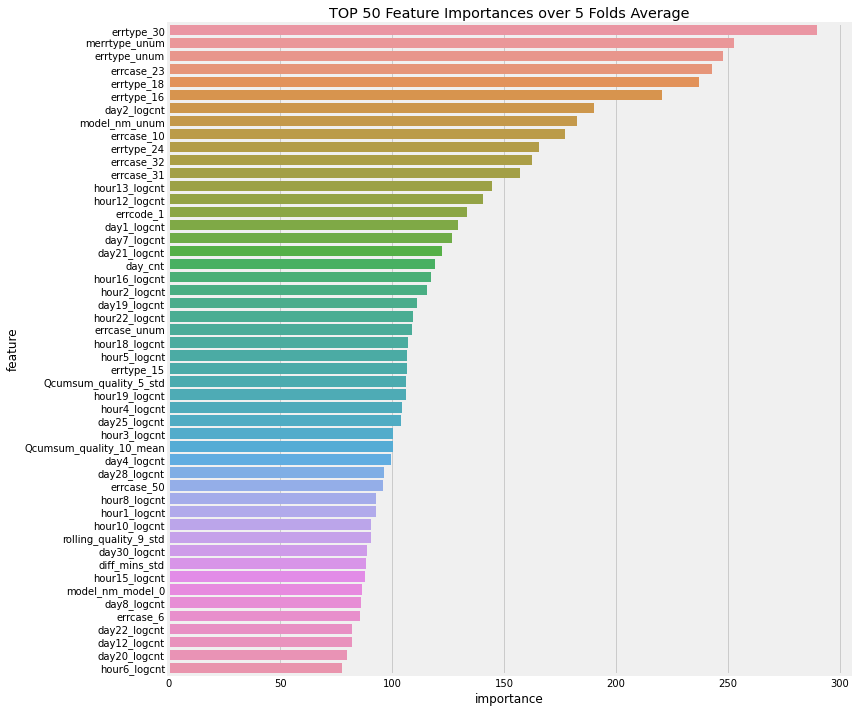

In [92]:
final_importance = feature_importance_df.groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()[:50]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",y="feature",data=final_importance)
plt.title('TOP 50 Feature Importances over 5 Folds Average')
plt.tight_layout()

In [83]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [89]:
## Bayes Optimization을 통하여 수행한 Parameters

param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 31,
    'max_depth': 8,
    'learning_rate': 0.01,
    'bagging_fraction': 0.7, 
    'feature_fraction': 0.7,
    'metric': 'auc',
    'verbose':-1
    }

In [90]:
# 717 
from catboost import Pool, CatBoostClassifier

n_seeds = 4
final_oof_lgb = np.zeros((len(train_x)))
final_pred = np.zeros((len(test_x)))
feature_importance_df = pd.DataFrame()

for _ in tqdm_notebook(range(n_seeds)):
    seed = np.random.randint(1000)
    oof_lgb = np.zeros((len(train_x)))
    pred_lgb = np.zeros((len(train_x)))
    fold_importance_df = pd.DataFrame()
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
        print('Fold Start!'.format(fold_+1))
        trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
        val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])

        num_round = 3000
        param['seed']= seed
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                        verbose_eval=200, early_stopping_rounds = 100)

        fold_importance_df["feature"] = train_x.columns
        fold_importance_df["importance"] = clf.feature_importance()
        oof_lgb[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)    
        pred_lgb = clf.predict(test_x, num_iteration=clf.best_iteration)    
    
    print("Seed: {}, CV score: {:<8.5f}".format(seed, roc_auc_score(train_y, oof_lgb)))
    print('='*80)
    final_oof_lgb += oof_lgb
    final_pred += pred_lgb
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print('='*80)
final_oof_lgb /= n_seeds
final_pred /= n_seeds
print('\nCross Validation Is Complete')     
print("Final CV score: {:<8.5f}".format(roc_auc_score(train_y, final_oof_lgb)))

Fold Start!
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.873709	valid_1's auc: 0.812102
[400]	training's auc: 0.904193	valid_1's auc: 0.816936
[600]	training's auc: 0.928197	valid_1's auc: 0.818072
Early stopping, best iteration is:
[604]	training's auc: 0.928695	valid_1's auc: 0.818207
Fold Start!
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.872105	valid_1's auc: 0.828474
[400]	training's auc: 0.9035	valid_1's auc: 0.831067
Early stopping, best iteration is:
[495]	training's auc: 0.915046	valid_1's auc: 0.831588
Fold Start!
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.872989	valid_1's auc: 0.825298
[400]	training's auc: 0.903318	valid_1's auc: 0.833329
[600]	training's auc: 0.927557	valid_1's auc: 0.835296
Early stopping, best iteration is:
[590]	training's auc: 0.926311	valid_1's auc: 0.835363
Fold Start!
Training until validation scores don't improve for 100 rou

In [58]:
prediction['problem'] = final_pred

In [59]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission = submission.drop('problem', axis=1)

In [60]:
submission = pd.merge(submission, prediction, how='left', on='user_id')

In [61]:
from datetime import date

today = date.today().strftime("%m-%d")
version=3

submission.to_csv(f'{today}_lgb_baseline_{version}.csv', index=False)

In [62]:
submission.shape

(14999, 2)

In [63]:
submission.head()

,user_id,problem
0,30000,0.938572
1,30001,0.369302
2,30002,0.347466
3,30003,0.722235
4,30004,0.920013
